## hough.ipynb
hough : A sciprt for testing hough transformation.
           
create   : 2019/11/06  
modified : 2019/11/07

### Define fundtions

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import math
%matplotlib inline

In [2]:
# RGB to gray
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [3]:
# convolution 2D
def conv2d(img, kernel, padding='same'):
    # Error handling
    if kernel.shape[0] != kernel.shape[1]:
        print("Use square filter!")
        return None
    
    if kernel.shape[0]%2 == 0 and kernel.shape[1]%2 == 0:
        print("filter size has to be odd")
        return None
    
    # Create result matrix
    result = np.zeros_like(img)
    
    # Calculate kernel size
    kernel_size = kernel.shape[0]
    
    # same padding
    if padding=='same':
        pad_size = int((kernel_size - 1) / 2)
    else:
        pad_size = 0
    img = np.pad(img, pad_size, mode='constant')
    
    # convolution
    width, height = img.shape
    offset = int(kernel_size / 2)
    for x in range(offset, width-offset):
        for y in range(offset, height-offset):
            result[x-offset, y-offset] = np.sum(img[x-offset:x+offset+1, y-offset:y+offset+1] * kernel)
            
    return result

In [4]:
# to define gradient x-axis with sobel filter
def grad_x(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return conv2d(img, kernel=sobel_x)

In [5]:
# to define gradient y-axis with sobel filter
def grad_y(img):
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return conv2d(img, kernel=sobel_y)

In [6]:
def edgeDetect(img, winSize=7, k=0.04, thd=1, type=0):
    """
    Parameters:
        img     = image (grayscale)
        winSize = total size of window for summation in pixels
        k       = empirical constant
        thd     = threshold
        type    = {0 - Eigenvalue, 1 - Harris}
    """
   
    # create empty matrix for result
    result = np.zeros_like(img)
    
    # get image size
    width, height = img.shape
    
    # compute derivatives using sobel kernel
    dx = grad_x(img)
    dy = grad_y(img)
    
    # For each pixel in img, determine second moment matrix H summed up over the window
    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2
    
    # Create matrix for saving second moment
    Sxx = np.zeros_like(Ixx)
    Sxy = np.zeros_like(Ixy)
    Syy = np.zeros_like(Iyy)
    
    # same padding
    pad_size = int((winSize - 1) / 2)
    Ixx = np.pad(Ixx, pad_size, mode='constant')
    Ixy = np.pad(Ixy, pad_size, mode='constant')
    Iyy = np.pad(Iyy, pad_size, mode='constant')
    
    # Calculate second moment matrix H summed up over the window
    offset = int(winSize / 2)
    for x in range(offset, width-offset):
        for y in range(offset, height-offset):
            Sxx[x-offset, y-offset] = np.sum(Ixx[x-offset:x+offset+1, y-offset:y+offset+1])
            Sxy[x-offset, y-offset] = np.sum(Ixy[x-offset:x+offset+1, y-offset:y+offset+1])
            Syy[x-offset, y-offset] = np.sum(Iyy[x-offset:x+offset+1, y-offset:y+offset+1])
        
    # Eigenvalue
    if type==0:
        lamda1 = (Sxx + Syy) + np.sqrt(4*Sxy**2 + (Sxx-Syy)**2)
        lamda2 = (Sxx + Syy) - np.sqrt(4*Sxy**2 + (Sxx-Syy)**2) # always minimum
        result = lamda1 - lamda2
        result[result < thd] = 0
        result[result >= thd] = 1
        
    # Harris
    elif type==1:
        det = (Sxx * Syy) - (Sxy**2)
        trace = Sxx + Syy
        r = det - k*(trace**2)
        result = r
        result[result < thd] = 0

    return result

In [7]:
def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=0, Verbose=False):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between 0 and 180 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    sTime = time.time()
    
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0.0, 180.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    if Verbose:
        print('num_thetas : %d' %num_thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1
    eTime = time.time()
    diffTime =(eTime - sTime)
    print('Time : %.2fsec' % diffTime)
    return accumulator, thetas, rhos, diffTime

In [8]:
def show_hough_line(img, accumulator, thetas, rhos, thd=200, save_path=None):
    fig, ax = plt.subplots(1, 3, figsize=(18, 15))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Input image')
    ax[0].axis('image')
    
    ax[1].imshow(result, cmap='gray')
    ax[1].set_title('Edge image')
    ax[1].axis('image')

    ax[2].imshow(accumulator, cmap='gray')
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_title('Hough transform')
    ax[2].set_xlabel('Angles (degrees)')
    ax[2].set_ylabel('Distance (pixels)')
    ax[2].axis('image')
    
    r_idx, theta_idx = np.nonzero(accumulator > thd)
    for r, theta in zip(r_idx, theta_idx):
        circle = mpl.patches.Circle((theta, r), radius=20, color='white', fill=False)
        ax[2].add_patch(circle)

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

### Load image

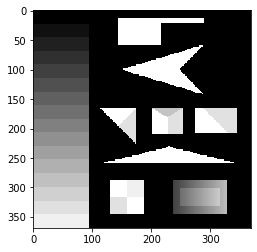

In [9]:
# read image
img = mpl.image.imread("img74.gif")
img = rgb2gray(img)
plt.imshow(img, cmap='gray')

### Edge detection 

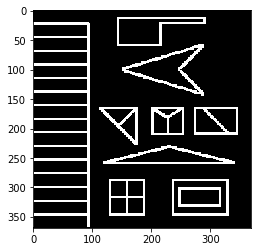

In [10]:
result = edgeDetect(img, winSize=3, k=0.04, thd=5500, type=0)
plt.imshow(result, cmap='gray')

### hough transformation

In [11]:
accumulator, thetas, rhos, diffTime0 = hough_line(result)

Time : 24.95sec


### Plot results

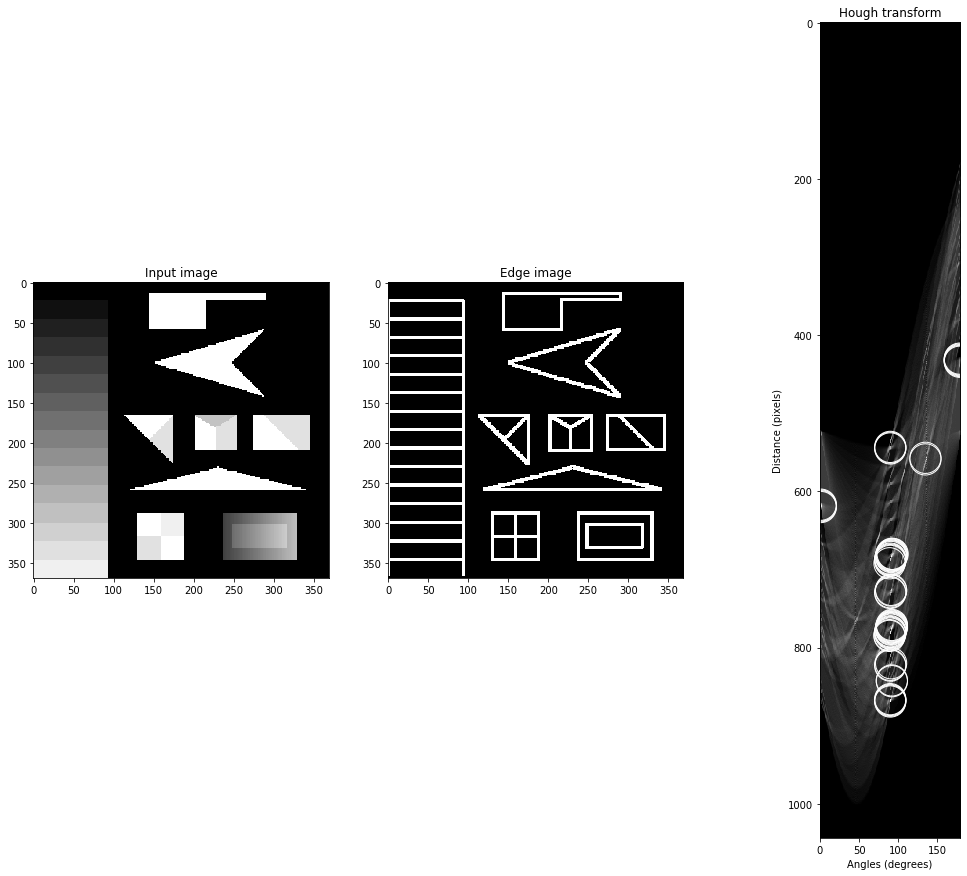

In [12]:
show_hough_line(img, accumulator, thetas, rhos, thd=175, save_path='output.png')

### (Bonus) Using the second method for determining theta frim the image gradients

In [13]:
# extension 2
def hough_line_2(img, angle_step=1, lines_are_white=True, value_threshold=0, Verbose=False):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between 0 and 180 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    sTime = time.time()
    
    # gradient
    dx = grad_x(img)
    dy = grad_y(img)
    magnitude = np.sqrt(dx**2 + dy**2)
    mag_avg = np.average(magnitude)
    
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(0.0, 180.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    if Verbose:
        print('num_thetas : %d' %num_thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        # Compute d and θ from gradient, compute edge strength e
        if magnitude[y, x] > mag_avg:
            for t_idx in range(num_thetas):
                # Calculate rho. diag_len is added for a positive index
                rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
                accumulator[rho, t_idx] += magnitude[y, x]
    eTime = time.time()
    diffTime =(eTime - sTime)
    print('Time : %.2fsec' % diffTime)
    return accumulator, thetas, rhos, diffTime

In [14]:
accumulator, thetas, rhos, diffTime1 = hough_line_2(result)

Time : 14.25sec


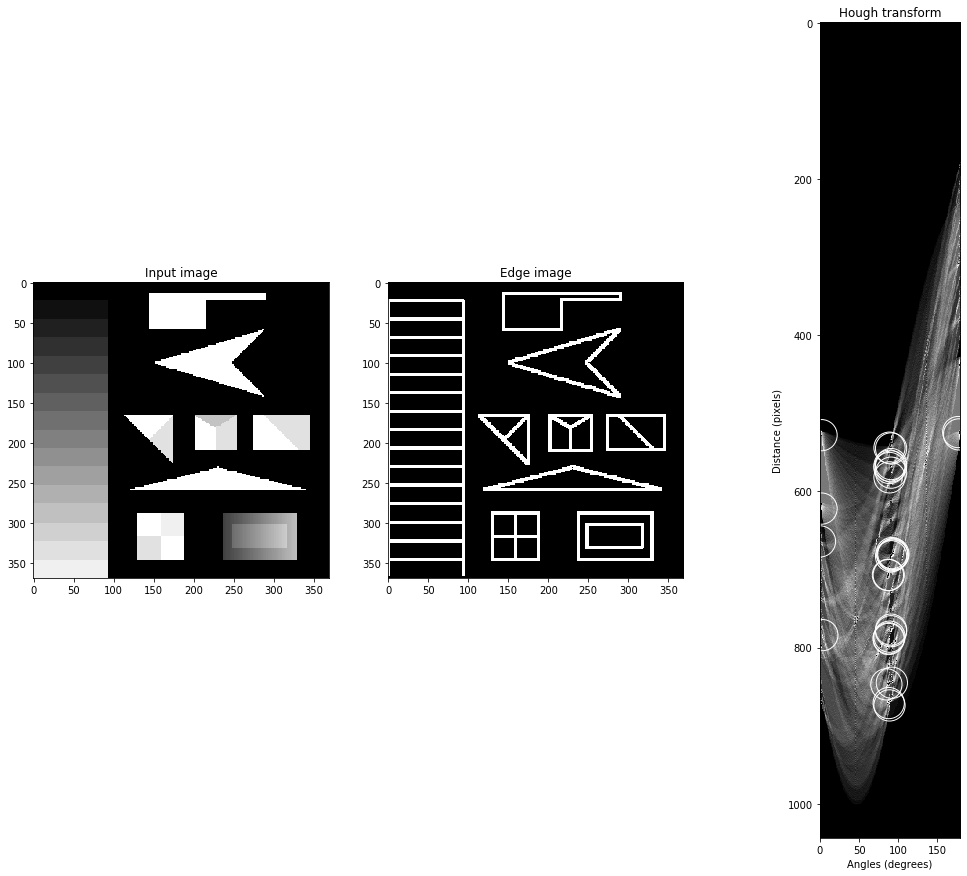

In [15]:
show_hough_line(img, accumulator, thetas, rhos, thd=250, save_path='bonus.png')

In [16]:
print(f'* method2 time({diffTime1:.2f}sec) is {diffTime0/diffTime1:.1f}times faster than original time({diffTime0:.2f}sec)')

* method2 time(14.25sec) is 0.6times faster than original time(24.95sec)
